In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import training_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np
from sklearn.manifold import TSNE

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

In [2]:
# =========================
# Shared Parameters
# =========================
n_classes = 6
class_proportions = np.array([0.4, 0.1, 0.05, 0.2, 0.15, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# sample sizes
n_samples_train    = 32768
n_samples_val      = 32768
n_samples_test     = 32768
n_samples_train_DA = 1024
n_samples_val_DA   = 1024

# seeds
seed_structure = 137
seed_train     = 42
seed_val       = 276
seed_test      = 0
seed_train_DA  = 1
seed_val_DA    = 2
seed_transform = 3

# =========================
# Create specs
# =========================
specs_target = [
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[0.0, 0.0], sigma=(1.5, 0.4), angle=np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[5.0, 1.0], sigma=(1.0, 0.2), angle=-np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[-2.0, -2.0], sigma=(0.6, 0.4), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[4.0, -6.0], sigma=(0.9, 0.6), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.4, 0.2), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[6.0, 2.0], sigma=(0.7, 0.7), angle=0),
    ], weights=[1.0]),
]

specs_source = [
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[0.0, 0.0], sigma=(1.5, 0.4), angle=np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, 0.0], sigma=(1.0, 0.2), angle=-np.pi/4),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[-5.0, -2.0], sigma=(0.6, 0.4), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.9, 0.6), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[2.0, -4.0], sigma=(0.4, 0.2), angle=0),
    ], weights=[1.0]),
    generate_toy_data.spec_mixture([
        generate_toy_data.spec_gaussian(center=[6.0, 2.0], sigma=(0.7, 0.7), angle=0),
    ], weights=[1.0]),
]

# =========================
# Generate Train/Val Source with the SAME shared specs and Target/Test with DIFFERENT shifted specs
# =========================
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_train, specs_source, class_proportions, seed=seed_train
)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_val, specs_source, class_proportions, seed=seed_val
)
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_specs(
    n_samples_test, specs_target, class_proportions, seed=seed_test
)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_specs(
    n_samples_train_DA, specs_target, class_proportions, seed=seed_train_DA
)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_specs(
    n_samples_val_DA, specs_target, class_proportions, seed=seed_val_DA
)

/home/dlopez/tmp/pip-tmp/ipykernel_65390/778364334.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.array(plt.cm.get_cmap("tab10").colors[:n_classes])


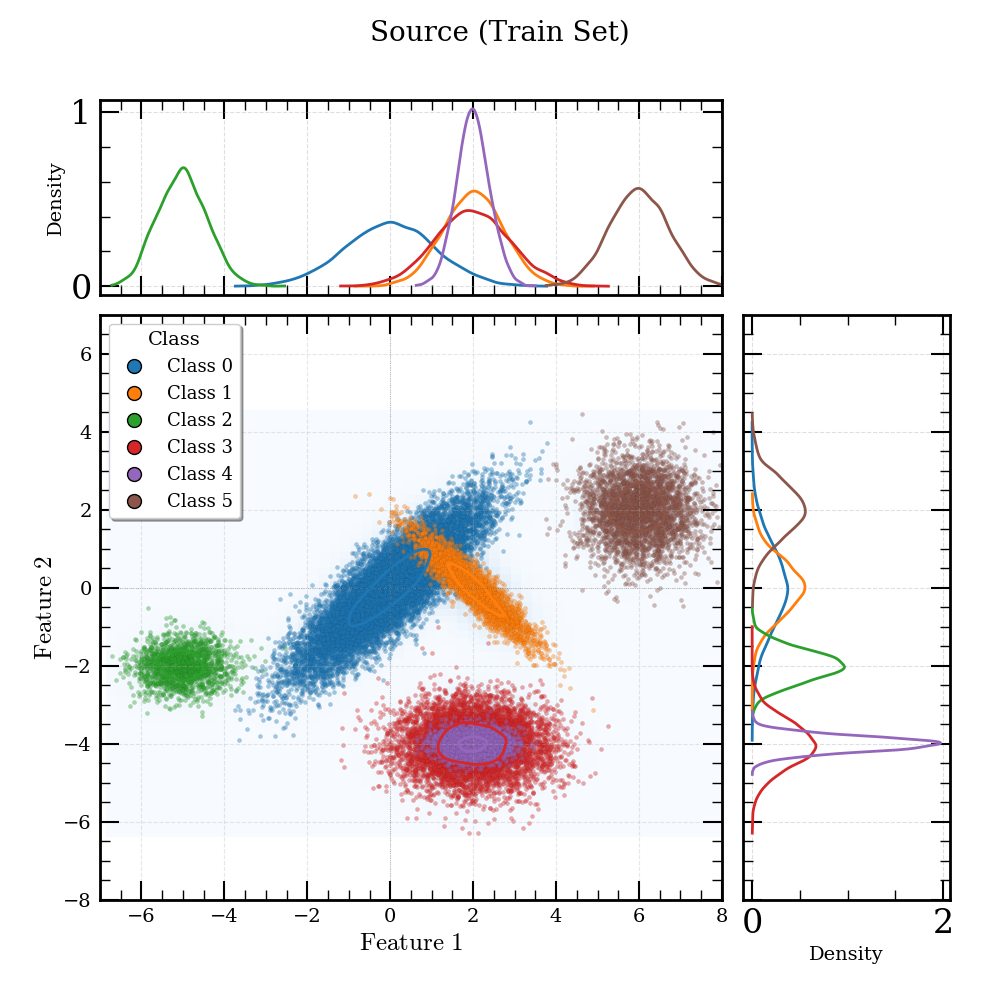

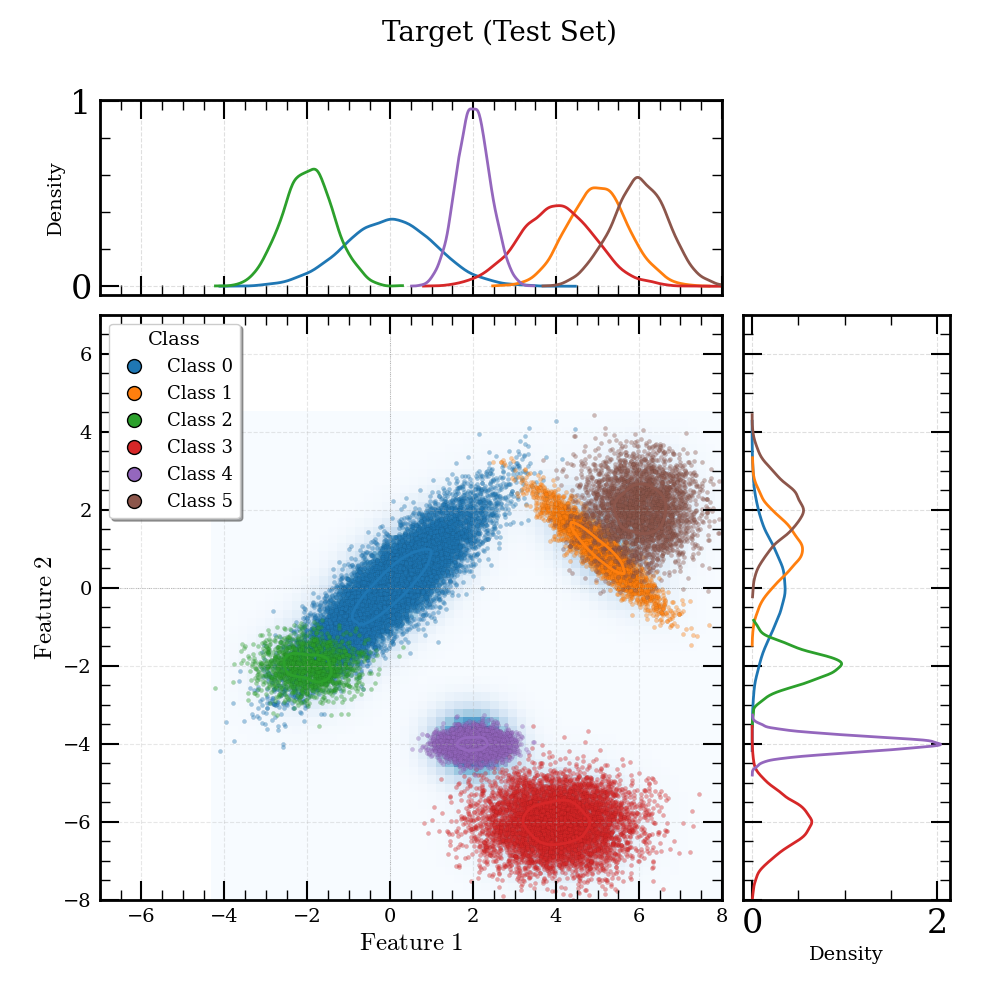

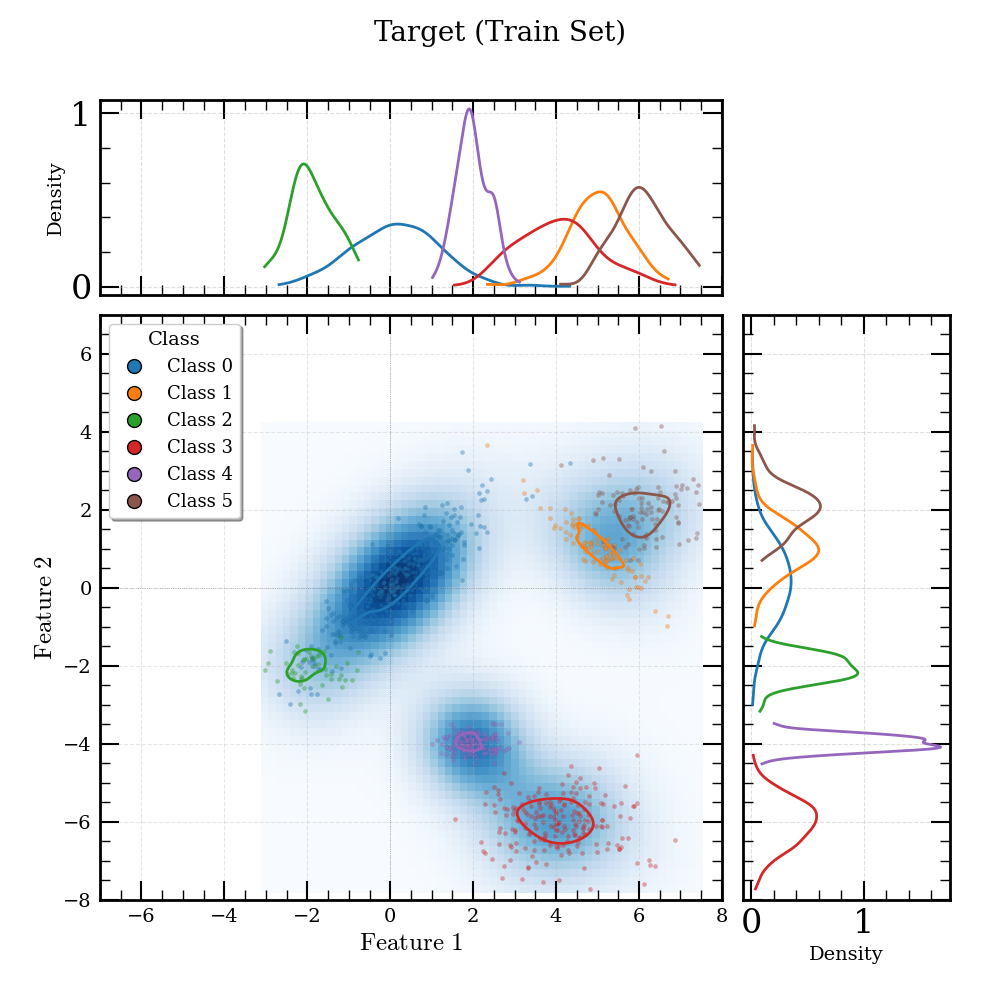

In [3]:
# === Visualize sets ===
classes = list(range(n_classes))
colors = np.array(plt.cm.get_cmap("tab10").colors[:n_classes])
color_dict = {cls: col for cls, col in zip(classes, colors)}

x_min, x_max = -7, 8
y_min, y_max = -8, 7

fig1, ax_main1 = plotting_utils.plot_2d_classification_with_kde(
    xx_train["OBS"], yy_train["SPECTYPE_int"], title="Source (Train Set)", class_color_dict=color_dict
)
ax_main1.set_xlim([x_min, x_max])
ax_main1.set_ylim([y_min, y_max])
plt.show()

# fig2, ax_main2 = plotting_utils.plot_2d_classification_with_kde(
# xx_val["OBS"], yy_val["SPECTYPE_int"], title="Source (Validation Set)", class_color_dict=color_dict
# )
ax_main1.set_xlim([x_min, x_max])
ax_main1.set_ylim([y_min, y_max])
# plt.show()

fig3, ax_main3 = plotting_utils.plot_2d_classification_with_kde(
    xx_test["OBS"], yy_test["SPECTYPE_int"], title="Target (Test Set)", class_color_dict=color_dict
)
ax_main3.set_xlim([x_min, x_max])
ax_main3.set_ylim([y_min, y_max])
plt.show()

fig4, ax_main4 = plotting_utils.plot_2d_classification_with_kde(
    xx_train_DA["OBS"], yy_train_DA["SPECTYPE_int"], title="Target (Train Set)", class_color_dict=color_dict
)
ax_main4.set_xlim([x_min, x_max])
ax_main4.set_ylim([y_min, y_max])
plt.show()

In [4]:
path_load = None # This will be employed when doing domain adaptation

path_load_encoder = os.path.join(path_load, "model_encoder.pt") if path_load else None
path_load_downstream = os.path.join(path_load, "model_downstream.pt") if path_load else None

In [5]:
dset_train = data_loaders.DataLoader(xx_train, yy_train)
dset_val = data_loaders.DataLoader(xx_val, yy_val)
hidden_layers_encoder = [24, 16, 8]
dropout_rates_encoder = [0.01, 0.01, 0.01]
output_dim_encoder = 2
use_batchnorm_encoder = False
hidden_layers_downstream = [16, 16]
dropout_rates_downstream = [0.01, 0.01]
use_batchnorm_downstream = False
batch_size_training = int(dset_train.NN_xx/128)
batch_size_val = np.min([n_samples_train_DA, n_samples_val_DA])


# dset_train = data_loaders.DataLoader(xx_train_DA, yy_train_DA)
# dset_val = data_loaders.DataLoader(xx_val_DA, yy_val_DA)
# hidden_layers_encoder = [16, 16]
# dropout_rates_encoder = [0.01, 0.01]
# output_dim_encoder = 2
# use_batchnorm_encoder = True
# hidden_layers_downstream = [16]
# dropout_rates_downstream = [0.01]
# use_batchnorm_downstream = True
# batch_size_training = int(dset_train.NN_xx/1)
# batch_size_val = np.min([n_samples_train_DA, n_samples_val_DA])


dset_test = data_loaders.DataLoader(xx_test, yy_test)

2025-11-07 07:36:47,018 - INFO - ├── 💿 Initializing DataLoader object with 32768 samples...
2025-11-07 07:36:47,020 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 13107 (40.00%), 1: 3276 (10.00%), 2: 1638 (5.00%), 3: 6553 (20.00%), 4: 4915 (15.00%), 5: 3279 (10.01%)]
2025-11-07 07:36:47,020 - INFO - ├── 💿 Initializing DataLoader object with 32768 samples...
2025-11-07 07:36:47,020 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 13107 (40.00%), 1: 3276 (10.00%), 2: 1638 (5.00%), 3: 6553 (20.00%), 4: 4915 (15.00%), 5: 3279 (10.01%)]
2025-11-07 07:36:47,020 - INFO - ├── 💿 Initializing DataLoader object with 32768 samples...
2025-11-07 07:36:47,021 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 13107 (40.00%), 1: 3276 (10.00%), 2: 1638 (5.00%), 3: 6553 (20.00%), 4: 4915 (15.00%), 5: 3279 (10.01%)]


In [6]:
# ───── Load or build encoder ─────
if path_load_encoder:
    assert os.path.isfile(path_load_encoder), f"❌ Encoder checkpoint not found: {path_load_encoder}"
    logging.info(f"📥 Loading encoder from checkpoint: {path_load_encoder}")

    config_encoder, model_encoder = save_load_tools.load_model_from_checkpoint(
        path_load_encoder,
        model_building_tools.create_mlp,
        override_dropout=dropout_rates_encoder,
        use_batchnorm=use_batchnorm_encoder,
    )
else:
    logging.info("🛠️ Building encoder model from configuration...")
    config_encoder = {
        'input_dim': dset_train.xx['OBS'].shape[-1],
        'hidden_layers': hidden_layers_encoder,
        'dropout_rates': dropout_rates_encoder,
        'output_dim': output_dim_encoder,
        'use_batchnorm': use_batchnorm_encoder,
        'use_layernorm_at_output': False,
        'init_method': 'xavier'
    }
    model_encoder = model_building_tools.create_mlp(**config_encoder)

model_encoder.eval()

# ───── Load or build downstream model ─────
if path_load_downstream:
    assert os.path.isfile(path_load_downstream), f"❌ Downstream checkpoint not found: {path_load_downstream}"
    logging.info(f"📥 Loading downstream model from checkpoint: {path_load_downstream}")

    config_downstream, model_downstream = save_load_tools.load_model_from_checkpoint(
        path_load_downstream,
        model_building_tools.create_mlp,
        override_dropout=dropout_rates_downstream,
        use_batchnorm=use_batchnorm_downstream,
    )
else:
    logging.info("🛠️ Building downstream model from configuration...")
    config_downstream = {
        'input_dim': output_dim_encoder,
        'hidden_layers': hidden_layers_downstream,
        'dropout_rates': dropout_rates_downstream,
        'output_dim': n_classes,
        'use_batchnorm': use_batchnorm_downstream,
        'use_layernorm_at_output': False,
        'init_method': 'xavier'
    }
    model_downstream = model_building_tools.create_mlp(**config_downstream)

model_downstream.eval()

2025-11-07 07:36:47,122 - INFO - 🛠️ Building encoder model from configuration...
2025-11-07 07:36:47,124 - INFO - 🛠️ Building downstream model from configuration...


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.01, inplace=False)
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.01, inplace=False)
  (6): Linear(in_features=16, out_features=6, bias=True)
)

In [7]:
# print(model_encoder)
# print(model_downstream)

In [8]:
sampling_strategy = "true_random"
freeze_downstream_model = False

path_save = global_setup.path_models
path_save += "/06_example_model" # "/06_example_model_Supervised"

In [9]:
if sampling_strategy == "true_random":
    counts = dset_train.class_counts
    total_samples = np.sum(counts)
    weights = total_samples / (n_classes * counts)
    class_weights = torch.tensor(weights, dtype=torch.float32)
if sampling_strategy == "class_random":
    class_weights = torch.tensor(np.ones(n_classes), dtype=torch.float32)

loss_function_dict = {
    "type": "CrossEntropyLoss",
    "sampling_strategy": sampling_strategy,
    "class_weights": class_weights,
    "l2_lambda": 0.0
}

In [10]:
min_val_loss = training_tools.train_model(
    dset_train=dset_train,
    model_encoder=model_encoder,
    model_downstream=model_downstream,
    loss_function_dict=loss_function_dict,
    freeze_downstream_model=freeze_downstream_model,
    dset_val=dset_val,
    NN_epochs=1024,
    NN_batches_per_epoch=1024,
    batch_size= batch_size_training,
    batch_size_val= batch_size_val,
    lr=1e-2,
    weight_decay=0.0001,
    clip_grad_norm=1.0,
    seed_mode="deterministic",
    seed=0,
    path_save=path_save,
    config_encoder=config_encoder,
    config_downstream=config_downstream
)

2025-11-07 07:36:47,915 - INFO - Directory '/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model' already exists.
2025-11-07 07:36:51,600 - INFO - Overwriting '/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model'...
2025-11-07 07:36:51,600 - INFO - Directory '/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model' has been overwritten.
2025-11-07 07:36:52,100 - INFO - 🚀 Starting training loop...
2025-11-07 07:36:52,101 - INFO - 
📚 Epoch 1/1024
2025-11-07 07:36:52,101 - INFO - 📚 Training 1024 batches...
2025-11-07 07:36:52,159 - INFO - 📊 Epoch Eval | train_loss: 1.707060, val_loss: 1.709006, lr: 1.00e-02
2025-11-07 07:36:52,159 - INFO - ✅ New best model!
2025-11-07 07:36:52,160 - INFO - Saving to: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model
2025-1

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/utils/plotting_utils.py:1346: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


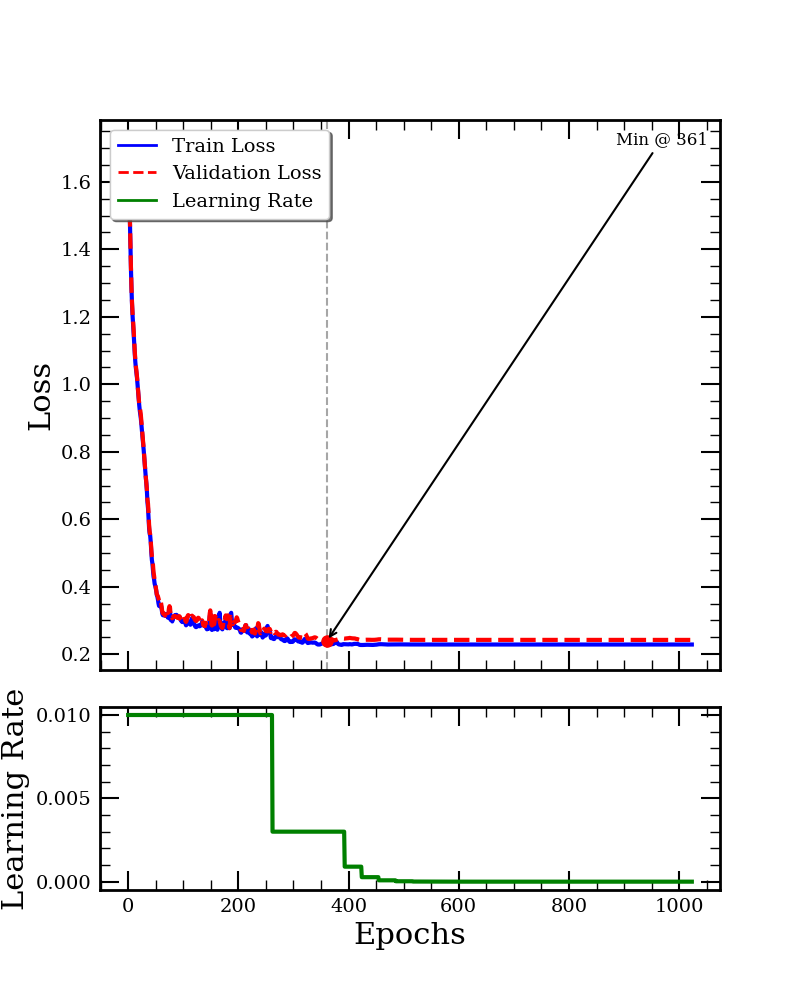

In [11]:
plotting_utils.plot_training_curves(path_save)

In [12]:
device = next(model_encoder.parameters()).device

In [13]:
unique_labels = dset_train.class_labels

# === Generate meshgrid from training data bounds ===

grid_res = 128
xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)

grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)
xx_grid = torch.tensor(grid_points, dtype=torch.float32, device=device)

# === Compute class probabilities and predicted class ===
with torch.no_grad():
    features_grid_points = model_encoder(xx_grid)
    logits_grid_points = model_downstream(features_grid_points)
    yy_pred_P_grid_points = torch.nn.functional.softmax(logits_grid_points, dim=1).cpu().numpy()
    yy_pred_grid_points = np.argmax(yy_pred_P_grid_points, axis=1)

In [14]:
# === Reshape to grid ===
Z = yy_pred_grid_points.reshape(grid_res, grid_res).astype(float)  # cast to float for gouraud shading

fig, ax = plt.subplots(figsize=(8, 7))

# Discrete colormap (but visually smoothed by gouraud)
unique_labels = np.unique(Z.astype(int))

cmap = plt.cm.get_cmap("tab10")
colors = np.array(cmap.colors[:n_classes])
class_color_dict = {cls: col for cls, col in zip(classes, colors)}

# Use boundaries to align ticks to color blocks
boundaries = np.arange(len(unique_labels) + 1) - 0.5
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(unique_labels))
pcm = ax.pcolormesh(xx_mesh, yy_mesh, Z, cmap=cmap, norm=norm, shading='nearest')

# Overlay training points using the same colormap
for ii, label in enumerate(unique_labels):

    mask = dset_train.yy["SPECTYPE_int"] == label
    tmp = dset_train.xx["OBS"][mask]
    ax.scatter(tmp[:, 0], tmp[:, 1], marker='^', s=120, alpha=0.9, color=class_color_dict[label],
               edgecolor='black', linewidth=0.4)
    
    mask = dset_val.yy["SPECTYPE_int"] == label
    tmp = dset_val.xx["OBS"][mask]
    ax.scatter(tmp[:, 0], tmp[:, 1], s=12, alpha=0.9, color=class_color_dict[label],
               edgecolor='black', linewidth=0.4)

# Styling
ax.set_title("Predicted Class Map", fontsize=18)
ax.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
ax.tick_params(labelsize=12)

# Colorbar (optional: no strict boundaries here due to gouraud shading)
cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Predicted Class", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks(np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

/home/dlopez/tmp/pip-tmp/ipykernel_65390/1189451935.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


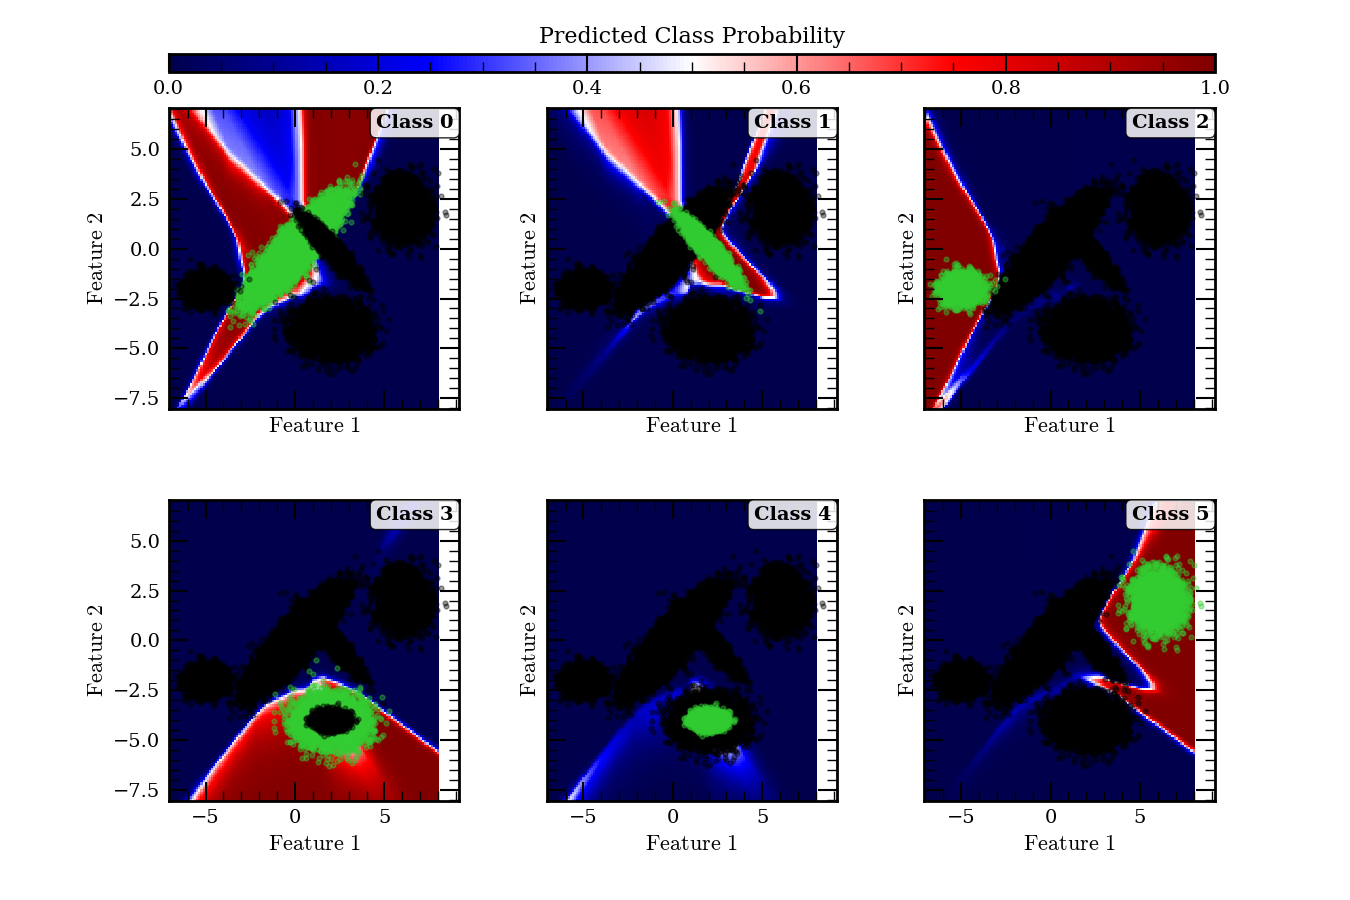

In [15]:
# === Reshape to grid ===
Z = yy_pred_P_grid_points.reshape(grid_res, grid_res, n_classes)

# Determine a roughly square grid layout
n_cols = np.ceil(np.sqrt(n_classes)).astype(int)
n_rows = np.ceil(n_classes / n_cols).astype(int)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4.5 * n_rows), sharex=True, sharey=True)
axs = np.array(axs).reshape(n_rows, n_cols)  # Ensure 2D array for indexing

vmin, vmax = 0.0, 1.0
cmap = "seismic"
pcm = None

for idx in range(n_classes):
    row, col = divmod(idx, n_cols)
    ax = axs[row, col]

    pcm = ax.pcolormesh(xx_mesh, yy_mesh, Z[..., idx], cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)

    # Annotate class index
    ax.text(
        0.98, 0.98, f"Class {idx}", transform=ax.transAxes, ha='right', va='top', fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.85)
    )

    ax.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
    ax.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

    for jj, label in enumerate(unique_labels):
        mask = dset_train.yy["SPECTYPE_int"] == label
        tmp = dset_train.xx["OBS"][mask]
        color = 'limegreen' if idx == jj else 'k'
        ax.scatter(tmp[:, 0], tmp[:, 1], s=12, alpha=0.4, color=color)

# Hide unused axes
for idx in range(n_classes, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axs[row, col].axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# === Shared horizontal colorbar at the top ===
pos0 = axs[0, 0].get_position()
posn = axs[-1, -1 if n_classes % n_cols != 0 else n_cols - 1].get_position()
cbar_ax = fig.add_axes([pos0.x0, pos0.y1 + 0.04, posn.x1 - pos0.x0, 0.02])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title("Predicted Class Probability", fontsize=16, pad=8)
cbar.ax.tick_params(labelsize=14)

plt.show()

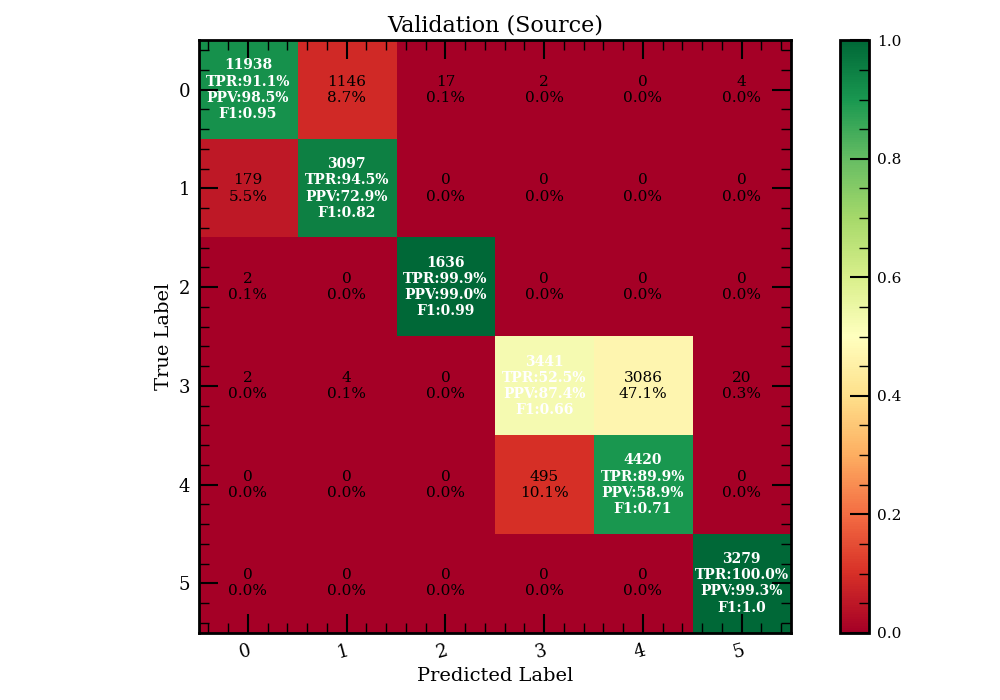

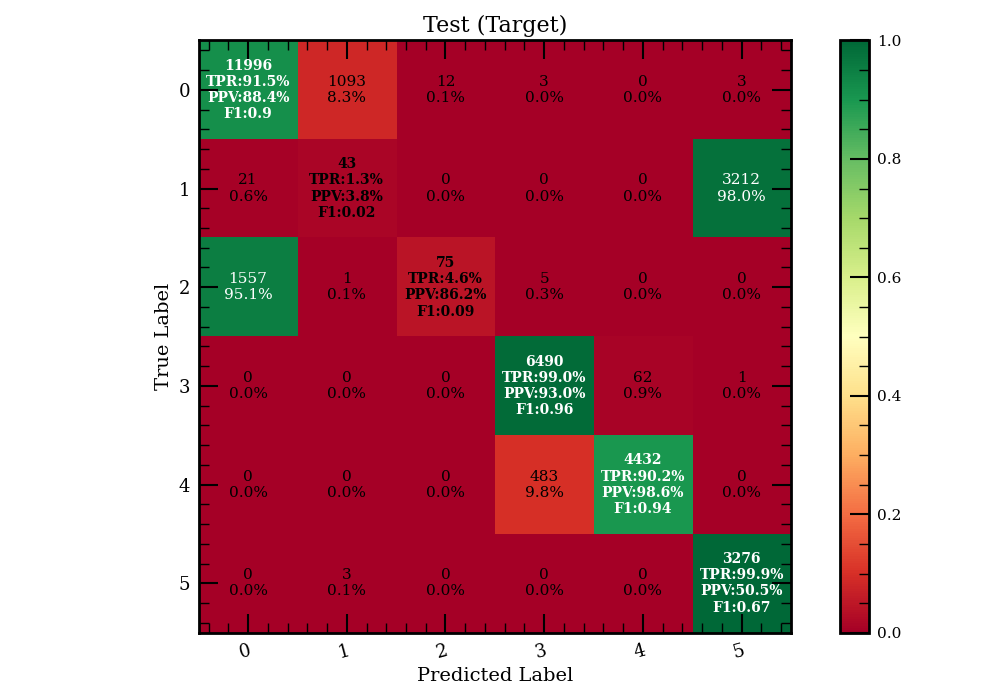

array([[11996,  1093,    12,     3,     0,     3],
       [   21,    43,     0,     0,     0,  3212],
       [ 1557,     1,    75,     5,     0,     0],
       [    0,     0,     0,  6490,    62,     1],
       [    0,     0,     0,   483,  4432,     0],
       [    0,     3,     0,     0,     0,  3276]])

In [16]:
# === Train ===
xx_train, yy_true_train = dset_train(batch_size=dset_train.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_train = model_encoder(xx_train)
        logits = model_downstream(features_train)
yy_pred_P_train = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_train = yy_pred_P_train.cpu().numpy()
yy_pred_train = np.argmax(yy_pred_P_train, axis=1)
yy_true_train = yy_true_train.cpu().numpy()
xx_train = xx_train.cpu().numpy()
features_train = features_train.cpu().numpy()

evaluation_tools.plot_confusion_matrix(
    yy_true_train, yy_pred_P_train,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="Training (Source)"
)


# === Val ===
xx_val, yy_true_val = dset_val(batch_size=dset_val.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_val = model_encoder(xx_val)
        logits = model_downstream(features_val)
yy_pred_P_val = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_val = yy_pred_P_val.cpu().numpy()
yy_pred_val = np.argmax(yy_pred_P_val, axis=1)
yy_true_val = yy_true_val.cpu().numpy()
xx_val = xx_val.cpu().numpy()
features_val = features_val.cpu().numpy()

evaluation_tools.plot_confusion_matrix(
    yy_true_val, yy_pred_P_val,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="Validation (Source)"
)


# === Test ===
xx_test, yy_true_test = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_test = model_encoder(xx_test)
        logits = model_downstream(features_test)
yy_pred_P_test = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_test = yy_pred_P_test.cpu().numpy()
yy_pred_test = np.argmax(yy_pred_P_test, axis=1)
yy_true_test = yy_true_test.cpu().numpy()
xx_test = xx_test.cpu().numpy()
features_test = features_test.cpu().numpy()

evaluation_tools.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="Test (Target)"
)

# Explore latent space

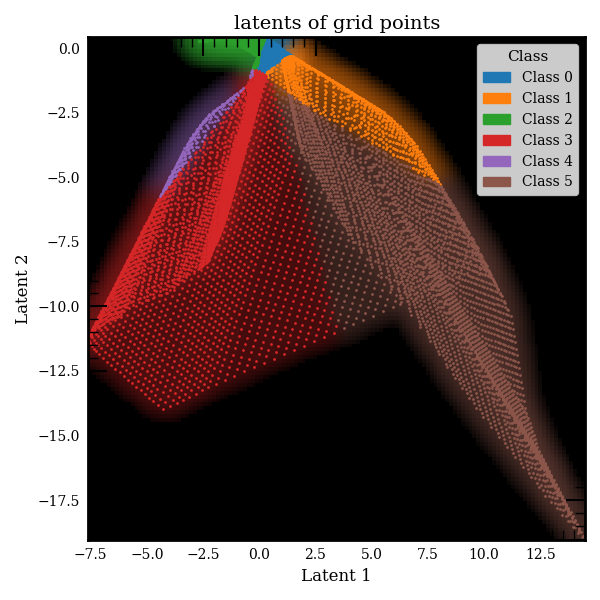

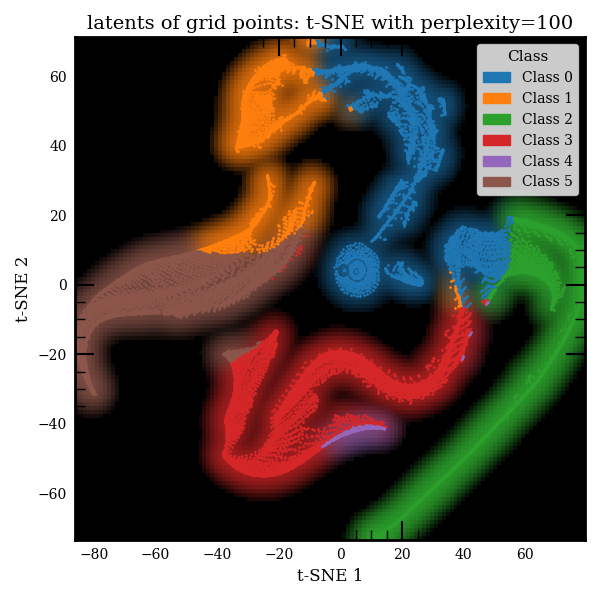

In [17]:
evaluation_tools.plot_latents_scatter(
    features_grid_points.cpu().numpy(),
    yy_pred_grid_points,
    class_counts=dset_test.class_counts,
    class_names=None,
    title="latents of grid points",
    n_bins=128,
    sigma=2.0,
    scatter_size=1.0,
    scatter_alpha=1.0,
    xlabel="Latent 1",
    ylabel="Latent 2"
)

# === Perform shared t-SNE projection ===
perplexity = 100
tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=42)
X_features_grid_points_tsne = tsne.fit_transform(features_grid_points.cpu().numpy())
evaluation_tools.plot_latents_scatter(
    X_features_grid_points_tsne,
    yy_pred_grid_points,
    class_counts=dset_test.class_counts,
    class_names=None,
    title="latents of grid points: t-SNE with perplexity="+str(perplexity),
    n_bins=128,
    sigma=2.0,
    scatter_size=1.0,
    scatter_alpha=1.0
)

In [18]:
feat_dict = {
    "latents_Source": features_val,
    "latents_Target": features_test
}

latents_tSNE = evaluation_tools.tsne_per_key(
    feat_dict,
    standardize=False,
    subsample=None,
    random_state=137,
    tsne_kwargs={"perplexity": 100},
    return_all_key=None,
)

2025-11-07 07:37:23,797 - INFO - t-SNE on N=65536 (perplexity=100)...


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 65536 samples in 0.010s...
[t-SNE] Computed neighbors for 65536 samples in 1.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 65536
[t-SNE] Computed conditional probabilities for sample 2000 / 65536
[t-SNE] Computed conditional probabilities for sample 3000 / 65536
[t-SNE] Computed conditional probabilities for sample 4000 / 65536
[t-SNE] Computed conditional probabilities for sample 5000 / 65536
[t-SNE] Computed conditional probabilities for sample 6000 / 65536
[t-SNE] Computed conditional probabilities for sample 7000 / 65536
[t-SNE] Computed conditional probabilities for sample 8000 / 65536
[t-SNE] Computed conditional probabilities for sample 9000 / 65536
[t-SNE] Computed conditional probabilities for sample 10000 / 65536
[t-SNE] Computed conditional probabilities for sample 11000 / 65536
[t-SNE] Computed conditional probabilities for sample 12000 / 65536
[t-SNE] Computed conditional probabilities for sa

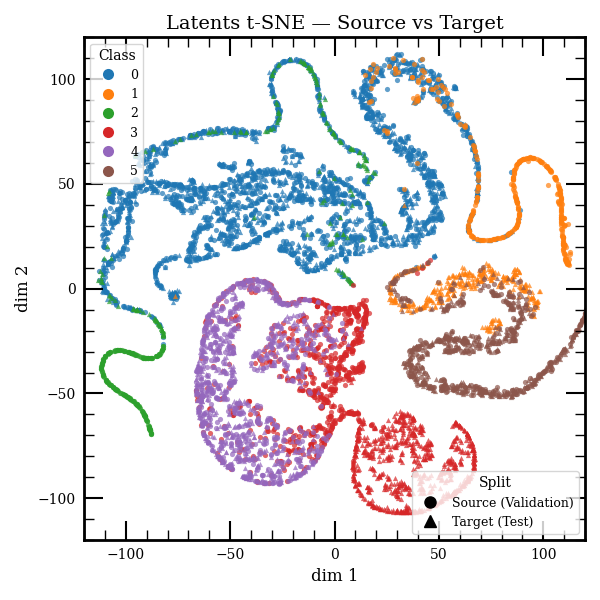

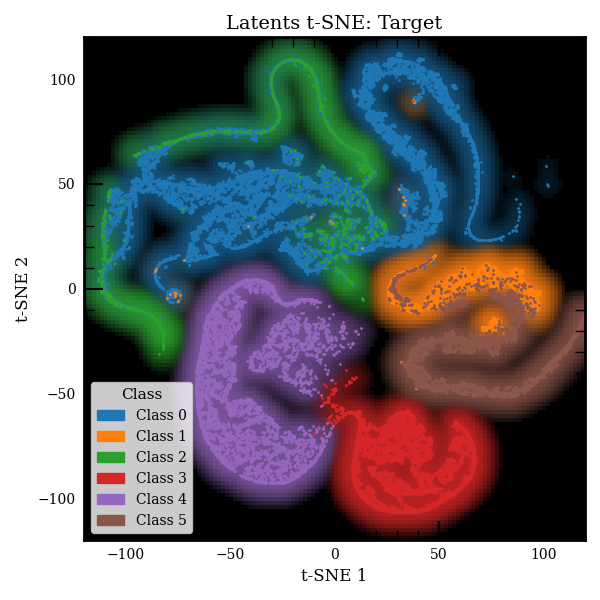

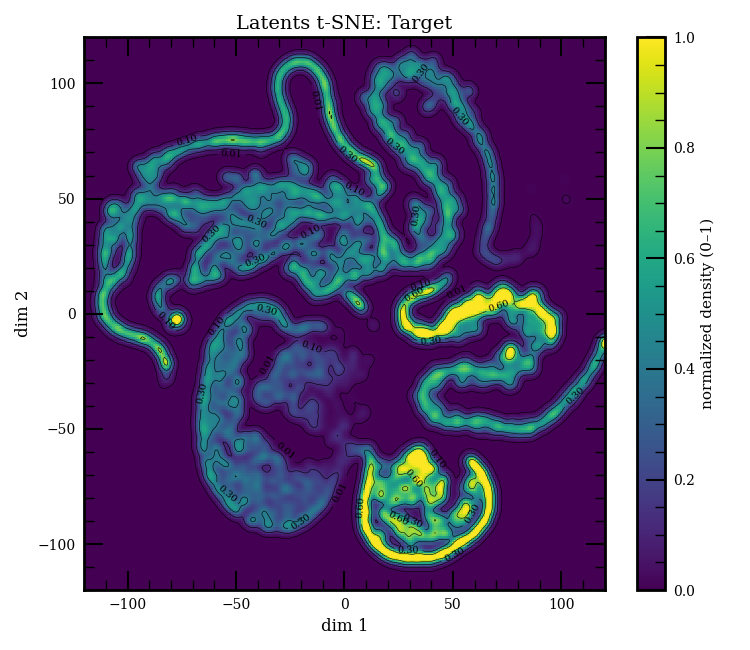

In [19]:
xlim = (-120, 120)
ylim = (-120, 120)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE["latents_Source_tSNE"], y_val=yy_true_val,
    X_test=latents_tSNE["latents_Target_tSNE"], y_test=yy_true_test,
    class_names=None,
    title="Latents t-SNE — Source vs Target",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Source (Validation)",
    legend_split_2="Target (Test)"
)

evaluation_tools.plot_latents_scatter(
    latents_tSNE["latents_Source_tSNE"], yy_true_val,
    class_counts=dset_val.class_counts,
    class_names=None,
    title="Latents t-SNE: Source",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE["latents_Source_tSNE"],
    title="Latents t-SNE: Source",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)

evaluation_tools.plot_latents_scatter(
    latents_tSNE["latents_Target_tSNE"], yy_true_test,
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents t-SNE: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE["latents_Target_tSNE"],
    title="Latents t-SNE: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)